In [48]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import pickle
import random
from sklearn.linear_model import LinearRegression
import smt
from smt.applications.mixed_integer import (
    MixedIntegerContext,
    MixedIntegerSamplingMethod,
    MixedIntegerKrigingModel
)

from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    IntegerVariable,
    OrdinalVariable,
    CategoricalVariable,
)
from smt.sampling_methods import LHS

dir_name = './091923fulltryvariablecost'
n_iter = 2
final_round = 1
N= 500
lowerbounds = [100,1,0,0,0,0, 1]
upperbounds = [10000,100,0.1,1,1,1, 2]

1
[(0, 0.5327253216247524), (1, 0.38196197293830436)]


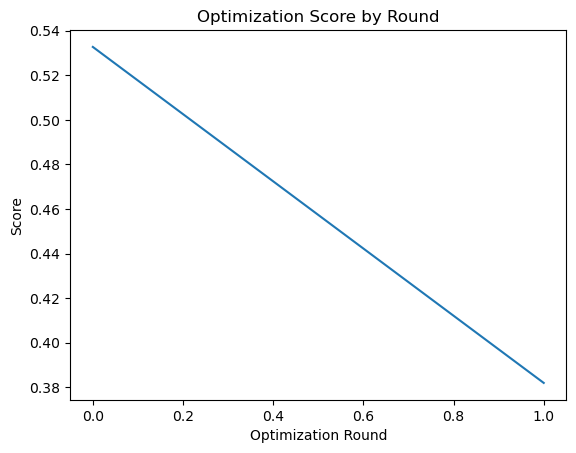

In [49]:
#OPTIMUM VALUE PLOT
allX = []
try:
    X_0 = np.loadtxt(dir_name+'/allXinit.txt')
except: 
    X_0 = np.loadtxt(dir_name+ '/allX0.txt')
allX.append(X_0)
for i in range(1,n_iter):
    print(i)
    X_i = np.loadtxt(dir_name+'/allX{}.txt'.format(i))
    allX.append(X_i)
optimum_value_tuples = []
for i in range(n_iter): 
    roun = i
    optimum = allX[i][0,-1]
    optimum_value_tuples.append((roun, optimum))
print(optimum_value_tuples)
optimum_array = np.array(optimum_value_tuples)
dataset = pd.DataFrame({'Optimization Round': optimum_array[:, 0], 'Score': optimum_array[:, 1]})
sns.lineplot(data = dataset, x = 'Optimization Round', y = 'Score').set_title("Optimization Score by Round")


#FILTER BAD VALUES
#X = X[np.where(X[:,-1] != 1.0)]
#LOAD SURROGATE
filename = dir_name+'/surrogate{}.pkl'.format(final_round)
with open(filename, "rb") as f:
   sm = pickle.load(f)


#PAIRPLOT OF SURROGATE AND REAL DATA


In [50]:

design_space = DesignSpace ([
    IntegerVariable (lowerbounds[0], upperbounds[0]), #Read Length
    FloatVariable (lowerbounds[1], upperbounds[1]), #Coverage
    FloatVariable (lowerbounds[2], upperbounds[2]), #error rate
    IntegerVariable (lowerbounds[3], upperbounds[3]), #number of single cells
    IntegerVariable (lowerbounds[4], upperbounds[4]), #paired or unpaired
    IntegerVariable (lowerbounds[5], upperbounds[5]), #WES OR WGS 0 is wgs 1 is wes
    IntegerVariable(lowerbounds[6], upperbounds[6]) # number of samples
])
random_state = random.randint(1,100)
sampling = MixedIntegerSamplingMethod (LHS , design_space, criterion ="ese", random_state = random_state) #random_state = random_state)
Xtest = sampling(N)
Ytest = sm.predict_values(Xtest)
Yvar = sm.predict_variances(Xtest)
final_surrogate_round = np.hstack((Xtest, Ytest))
final_rounds = allX[-1]
rounds = []
for i in final_rounds:
    for j in range(n_iter):
        if(j == 0):
            try:
                checking_array = np.loadtxt(dir_name+'/allX{}.txt'.format(j))
            except:
                checking_array = np.loadtxt(dir_name+'/allXinit.txt')
        else:
            checking_array = np.loadtxt(dir_name+'/allX{}.txt'.format(j))
        if(np.any(np.all(i == checking_array, axis=1))): 
            rounds.append(j)
            break
print(rounds)
print(len(rounds))
rounds = np.array(rounds)
n_rounds = rounds.shape[0]
rounds = rounds.reshape((n_rounds,1))
print(rounds.shape)
print(final_rounds.shape)
final_rounds = np.column_stack((final_rounds, rounds))

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0442779
   
   Prediction time/pt. (sec) :  0.0000886
   
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
36
(36, 1)
(36, 8)


    Read Length   Coverage  Error Rate  N_Single_Cells  Paired  Exome  \
0   4690.000000  97.089765    0.056514             1.0     1.0    0.0   
1   5231.999880  65.989199    0.073334             0.0     1.0    0.0   
2   5055.000000  97.815266    0.039892             1.0     1.0    0.0   
3   4713.000000  89.599090    0.029764             1.0     1.0    0.0   
4   5249.999862  16.222008    0.073572             1.0     1.0    0.0   
5   5250.000000  13.978299    0.058512             1.0     1.0    0.0   
6    662.000245  72.284788    0.030876             1.0     1.0    0.0   
7   5232.000000  65.983212    0.073901             0.0     1.0    0.0   
8   5250.000000  16.213213    0.074047             1.0     1.0    0.0   
9   5250.000000   9.812290    0.060056             1.0     1.0    0.0   
10   662.000000  72.282613    0.030777             1.0     1.0    0.0   
11  2402.000000  91.032288    0.055184             1.0     0.0    0.0   
12  2402.000156  91.034983    0.054862             

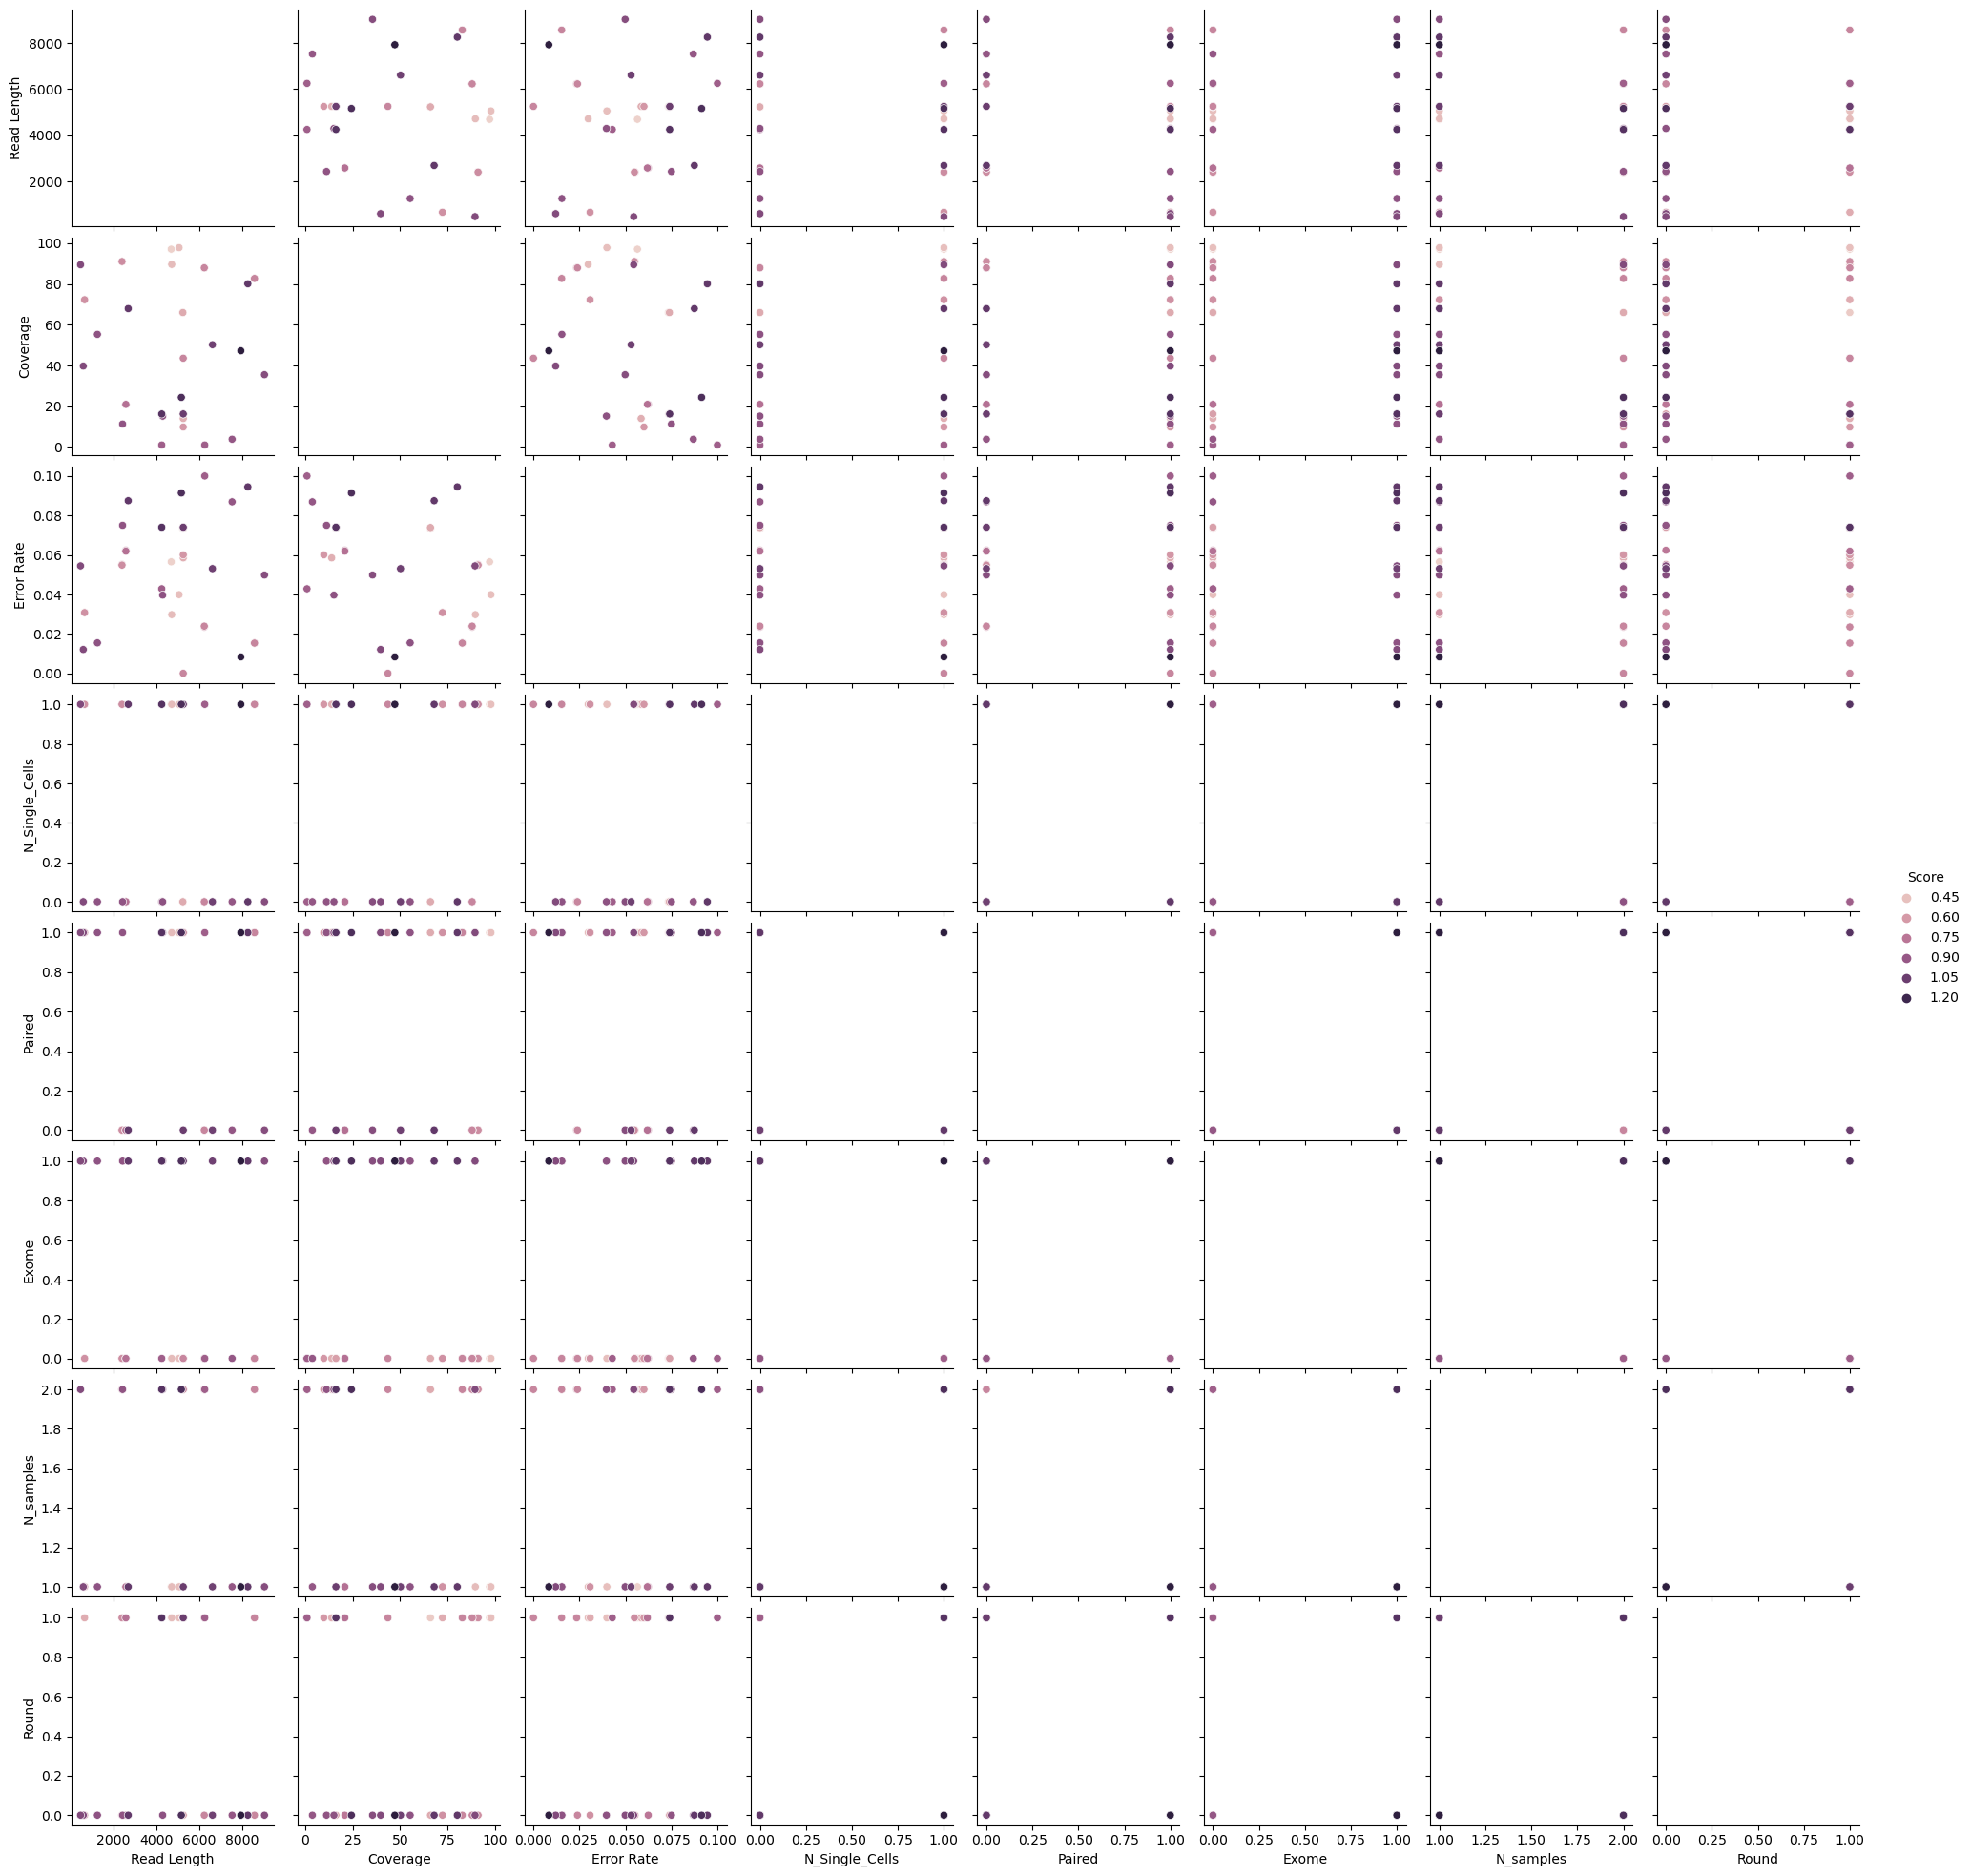

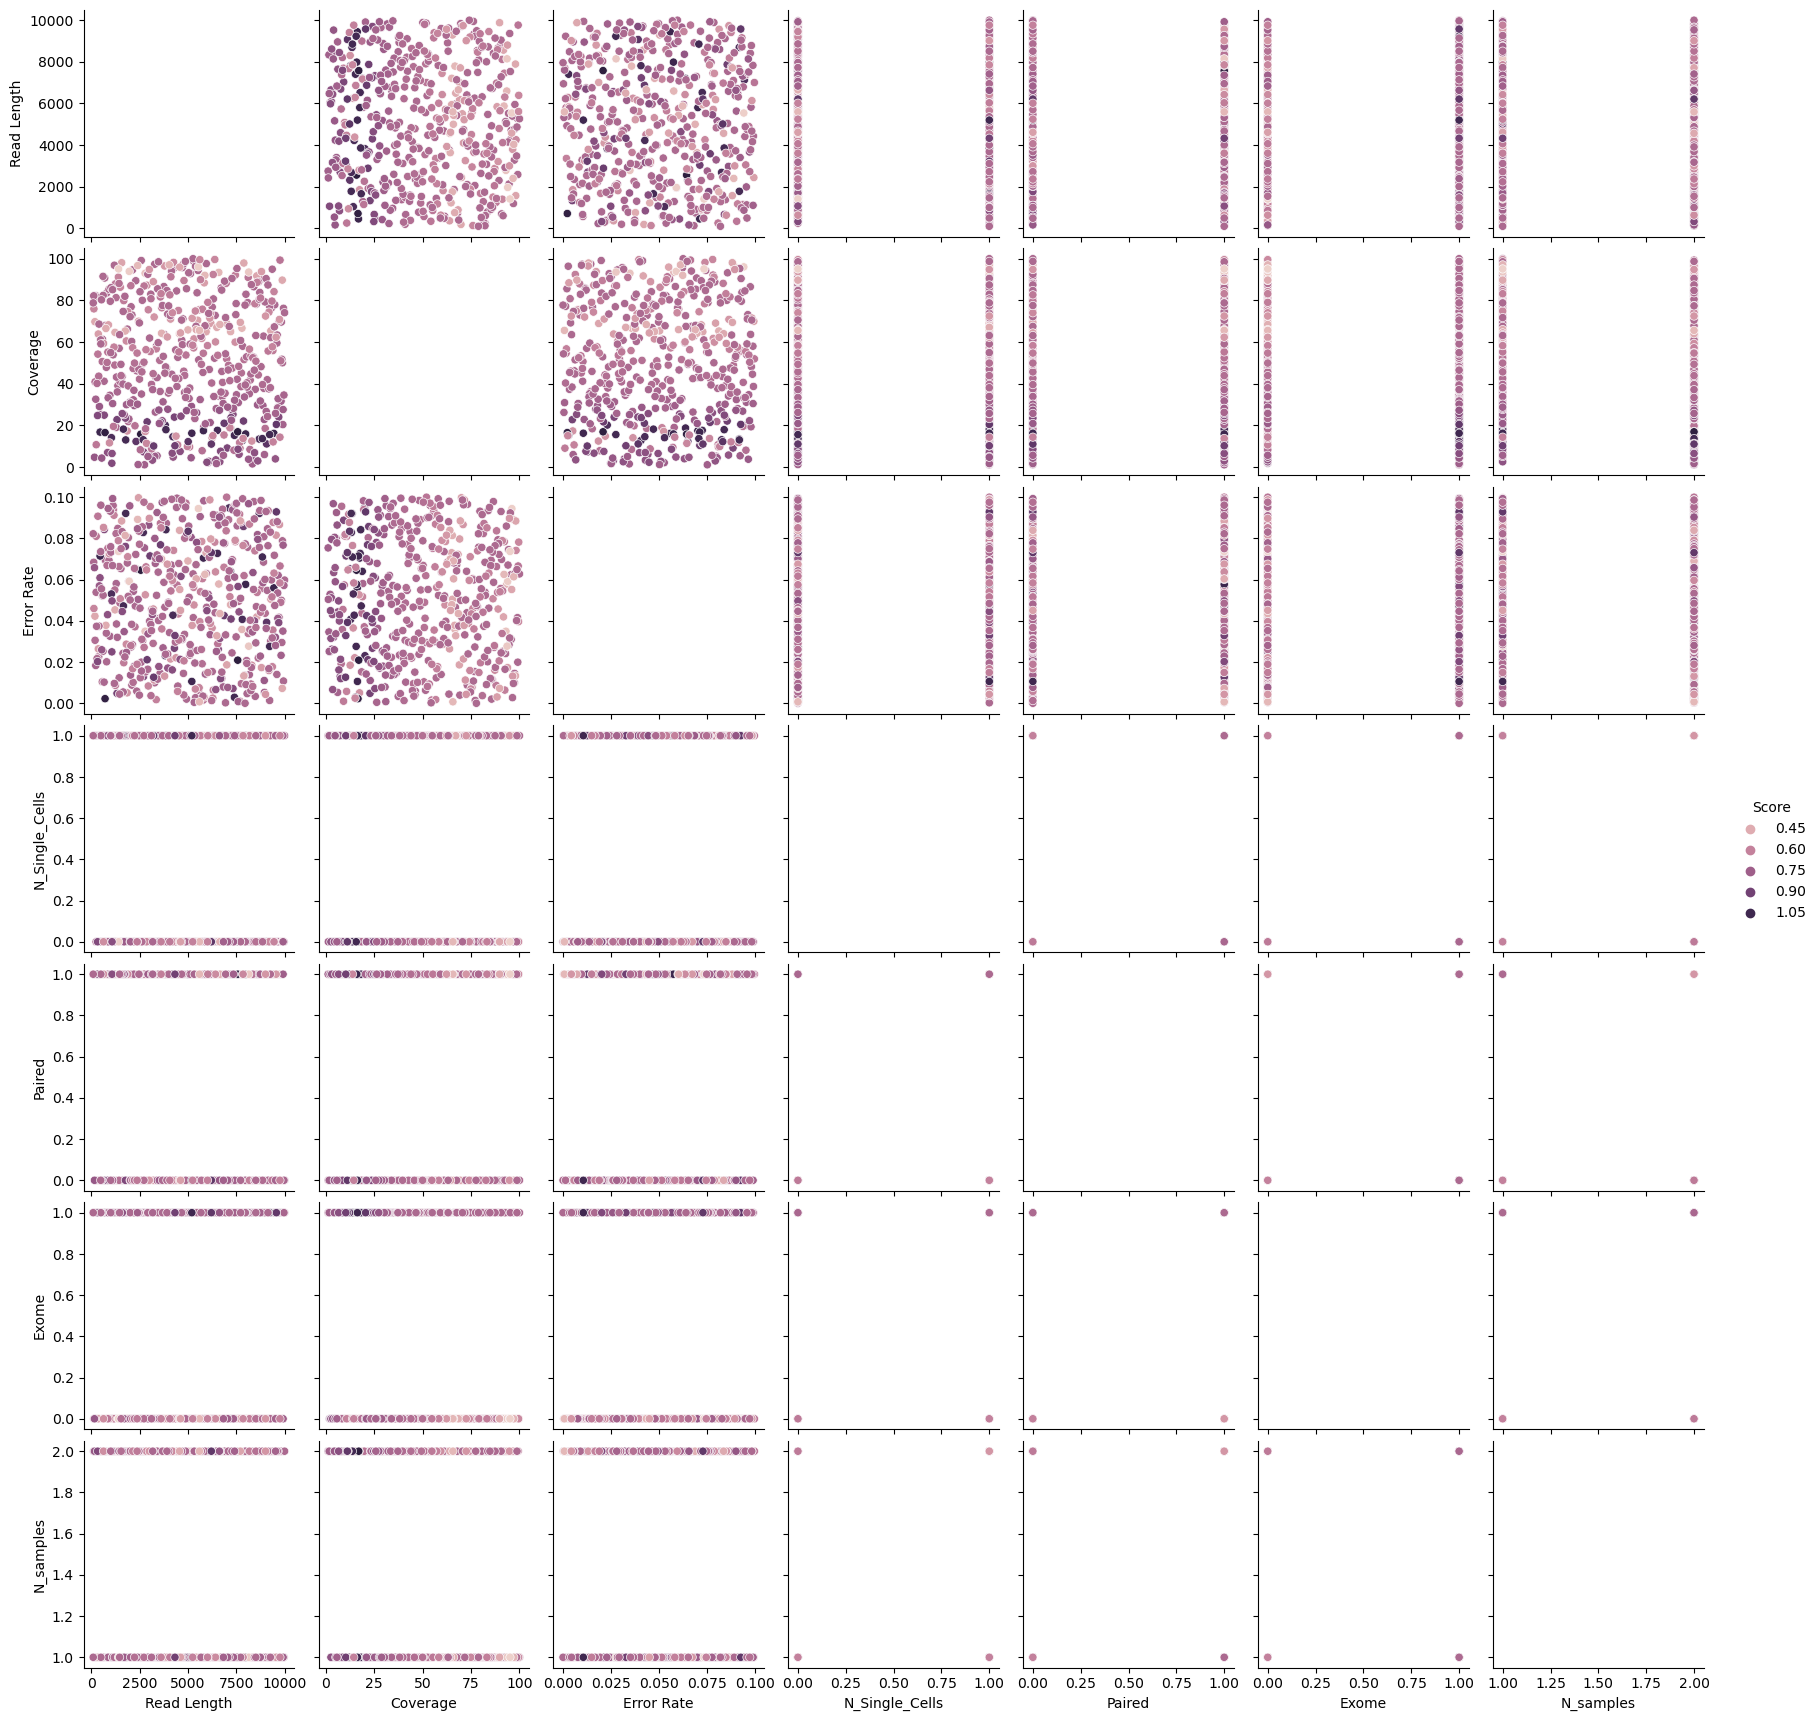

In [51]:


#Throw out outliers 
#final_rounds = final_rounds[:-1, :]

final_dataset = pd.DataFrame({'Read Length':final_rounds[:,0], "Coverage":final_rounds[:,1], "Error Rate":final_rounds[:,2], "N_Single_Cells":final_rounds[:,3],"Paired":final_rounds[:,4], "Exome":final_rounds[:,5], "N_samples":final_rounds[:,6] , "Score":final_rounds[:,7], "Round":final_rounds[:,8]}
                                            )
final_dataset.Paired = final_dataset.Paired.round()
final_dataset.Exome = final_dataset.Exome.round()
final_dataset.N_samples = final_dataset.N_samples.round()
final_dataset.N_Single_Cells = final_dataset.N_Single_Cells.round()
final_dataset['Round'] = final_dataset['Round'].astype('int')
#FILTER OUT NONSENSE VALUES HERE
final_dataset = final_dataset[final_dataset['Score'] != 1.0]
final_dataset = final_dataset[final_dataset['Score'] < 3]
print(final_dataset)

#the_palette = sns.color_palette("bright", n_colors = 3)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap = sns.color_palette(flatui).as_hex()
#PAIRPLOTS FOR SURROGATE AND REAL RESULTS
final_surrogate_dataset = pd.DataFrame({'Read Length':final_surrogate_round[:,0], "Coverage":final_surrogate_round[:,1], "Error Rate":final_surrogate_round[:,2], "N_Single_Cells":final_surrogate_round[:,3],"Paired":final_surrogate_round[:,4], "Exome":final_surrogate_round[:,5], "N_samples":final_surrogate_round[:,6] , "Score":final_surrogate_round[:,7]})
final_surrogate_dataset.Paired = final_surrogate_dataset.Paired.round()
final_surrogate_dataset.Exome = final_surrogate_dataset.Exome.round()
final_surrogate_dataset.N_samples = final_surrogate_dataset.N_samples.round()
final_surrogate_dataset.N_Single_Cells = final_surrogate_dataset.N_Single_Cells.round()
sns.pairplot(final_dataset,hue = "Score")
sns.pairplot(final_surrogate_dataset, hue = 'Score', diag_kind = 'kde')

In [52]:
print(final_surrogate_dataset)

     Read Length   Coverage  Error Rate  N_Single_Cells  Paired  Exome  \
0         5560.0  51.462845    0.006339             0.0     1.0    1.0   
1         7647.0   6.150716    0.044327             1.0     1.0    1.0   
2         5505.0  70.461804    0.038890             1.0     1.0    0.0   
3         8484.0  37.314346    0.003390             1.0     0.0    1.0   
4         5737.0   7.842142    0.019168             0.0     1.0    0.0   
..           ...        ...         ...             ...     ...    ...   
495       3180.0  37.173217    0.044650             0.0     1.0    1.0   
496       9016.0  72.472236    0.004350             1.0     1.0    0.0   
497        105.0  78.783541    0.082180             1.0     1.0    1.0   
498       2374.0  54.704459    0.018949             0.0     0.0    0.0   
499       9760.0  14.359955    0.058349             1.0     0.0    0.0   

     N_samples     Score  
0          2.0  0.702948  
1          1.0  0.803690  
2          2.0  0.478635  
3  

    Read Length   Coverage  Error Rate  N_Single_Cells  Paired  Exome  \
0   4690.000000  97.089765    0.056514             1.0     1.0    0.0   
1   5231.999880  65.989199    0.073334             0.0     1.0    0.0   
2   5055.000000  97.815266    0.039892             1.0     1.0    0.0   
3   4713.000000  89.599090    0.029764             1.0     1.0    0.0   
4   5249.999862  16.222008    0.073572             1.0     1.0    0.0   
5   5250.000000  13.978299    0.058512             1.0     1.0    0.0   
6    662.000245  72.284788    0.030876             1.0     1.0    0.0   
7   5232.000000  65.983212    0.073901             0.0     1.0    0.0   
8   5250.000000  16.213213    0.074047             1.0     1.0    0.0   
9   5250.000000   9.812290    0.060056             1.0     1.0    0.0   
10   662.000000  72.282613    0.030777             1.0     1.0    0.0   
11  2402.000000  91.032288    0.055184             1.0     0.0    0.0   
12  2402.000156  91.034983    0.054862             

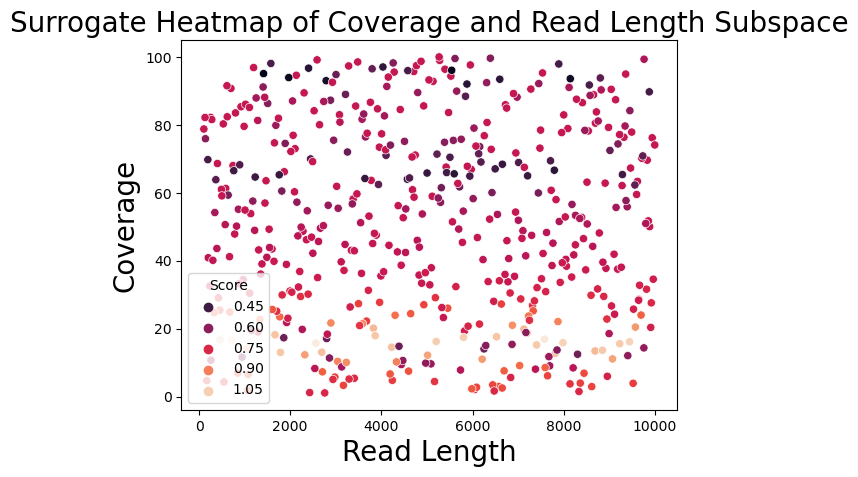

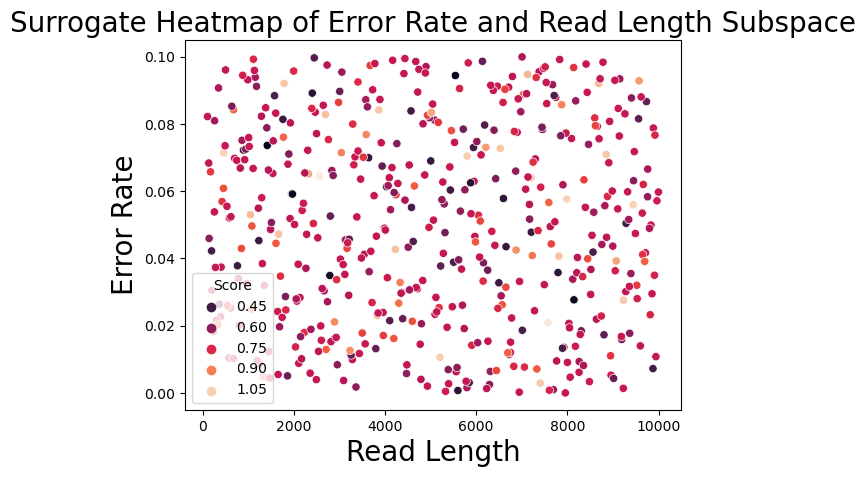

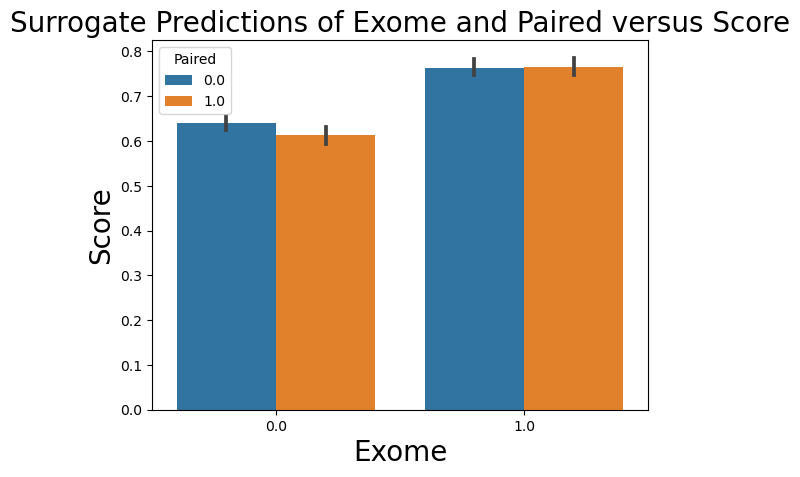

Text(0, 0.5, 'Error Rate')

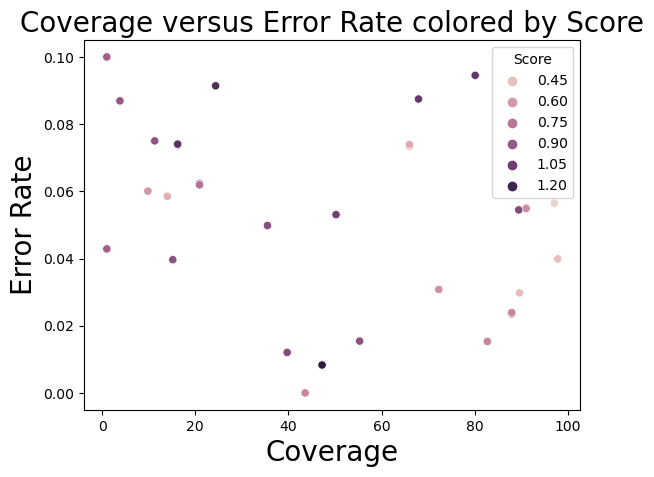

In [53]:
print(final_dataset)
#pick plots you care about here
a = sns.scatterplot(data = final_surrogate_dataset, x = "Read Length", y = "Coverage", hue = "Score", palette = "rocket")
a.set_title("Surrogate Heatmap of Coverage and Read Length Subspace", fontsize=20)
a.set_xlabel("Read Length", fontsize = 20)
a.set_ylabel("Coverage", fontsize = 20)
plt.show()
plt.close()
a = sns.scatterplot(data = final_surrogate_dataset, x = "Read Length", y = "Error Rate", hue = "Score", palette = "rocket")
a.set_title("Surrogate Heatmap of Error Rate and Read Length Subspace", fontsize=20)
a.set_xlabel("Read Length", fontsize = 20)
a.set_ylabel("Error Rate", fontsize = 20)
plt.show()
plt.close()
a = sns.barplot(data = final_surrogate_dataset, x = "Exome",hue ="Paired", y = "Score")
a.set_title("Surrogate Predictions of Exome and Paired versus Score", fontsize=20)
a.set_xlabel("Exome", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.scatterplot(data = final_dataset, x = "Coverage", y = "Error Rate", hue = "Score")
a.set_title("Coverage versus Error Rate colored by Score", fontsize=20)
a.set_xlabel("Coverage", fontsize = 20)
a.set_ylabel("Error Rate", fontsize = 20)

[0.31758851] [1.1116446]


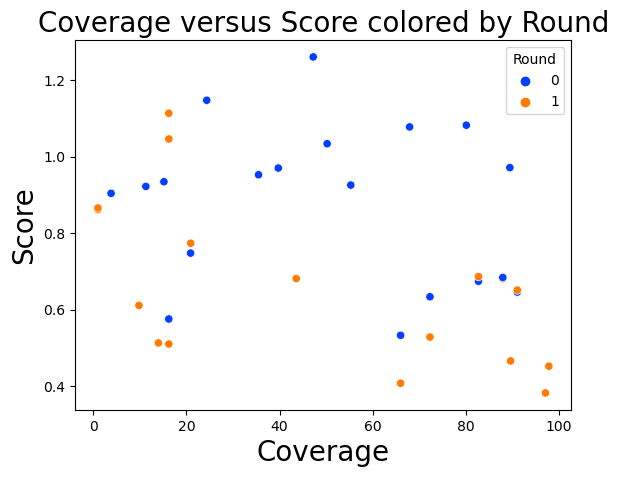

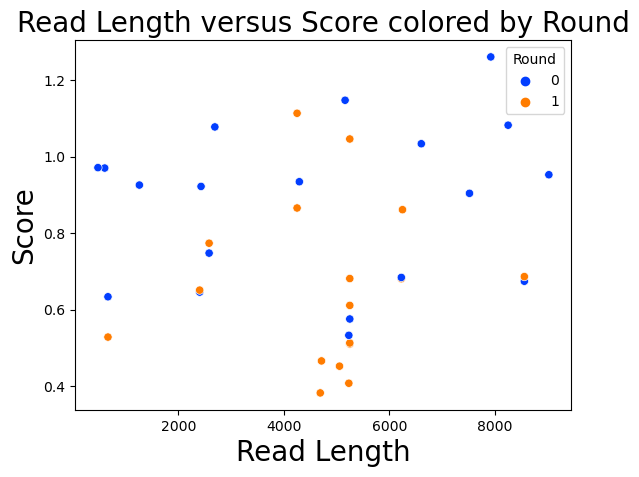

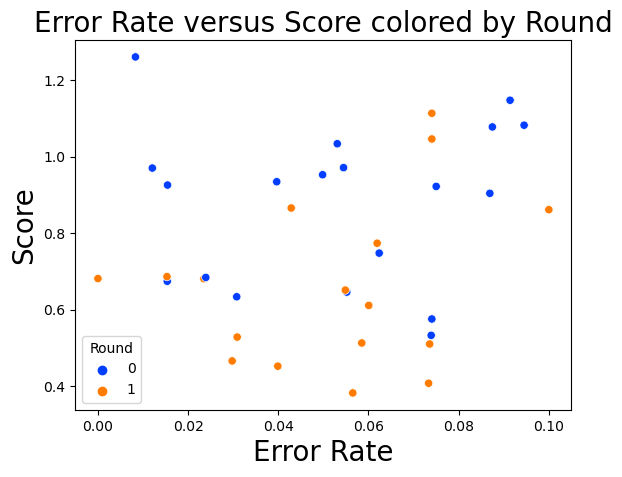

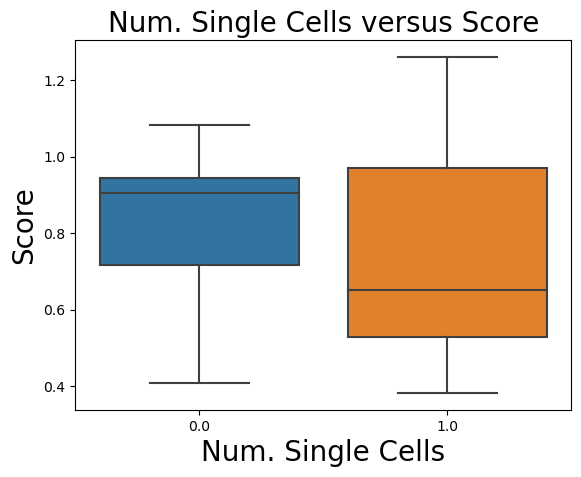

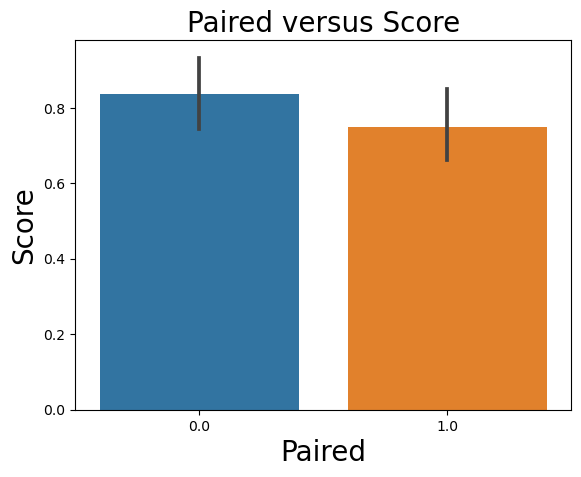

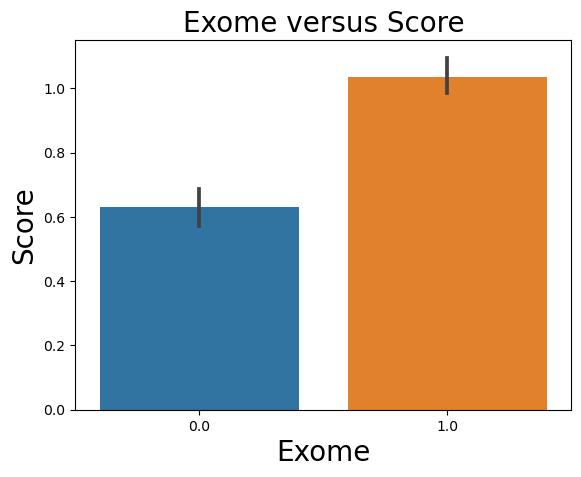

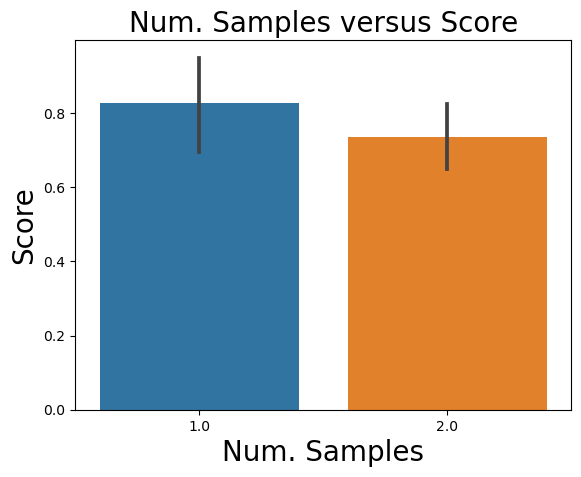

In [54]:
print(min(Ytest), max(Ytest))
a = sns.scatterplot(data=final_dataset, x="Coverage", y="Score", hue = "Round", legend = 'full', palette = 'bright')
a.set_title("Coverage versus Score colored by Round", fontsize=20)
a.set_xlabel("Coverage", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.scatterplot(data=final_dataset, x="Read Length", y="Score", hue = "Round", legend = 'full', palette = 'bright')
a.set_title("Read Length versus Score colored by Round", fontsize=20)
a.set_xlabel("Read Length", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.scatterplot(data=final_dataset, x="Error Rate", y="Score", hue = "Round", legend = 'full', palette = 'bright')
a.set_title("Error Rate versus Score colored by Round", fontsize=20)
a.set_xlabel("Error Rate", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.boxplot(data=final_dataset, x="N_Single_Cells", y="Score")
a.set_title("Num. Single Cells versus Score", fontsize=20)
a.set_xlabel("Num. Single Cells", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.barplot(data=final_dataset, x="Paired", y="Score")
a.set_title("Paired versus Score", fontsize=20)
a.set_xlabel("Paired", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.barplot(data=final_dataset, x="Exome", y="Score")
a.set_title("Exome versus Score", fontsize=20)
a.set_xlabel("Exome", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()
a = sns.barplot(data=final_dataset, x="N_samples", y="Score")
a.set_title("Num. Samples versus Score", fontsize=20)
a.set_xlabel("Num. Samples", fontsize = 20)
a.set_ylabel("Score", fontsize = 20)
plt.show()
plt.close()

[0.23506557 0.20807458]
[7.69652674 7.24118727]
[[ 0.04185077 -0.3694432   0.36417919 -0.50535359 -0.41575237  0.43689537
  -0.33169851]
 [ 0.22587088 -0.55835245  0.49125259  0.13488682  0.28300391 -0.06688762
   0.5414205 ]]
(36, 2) (36, 1)


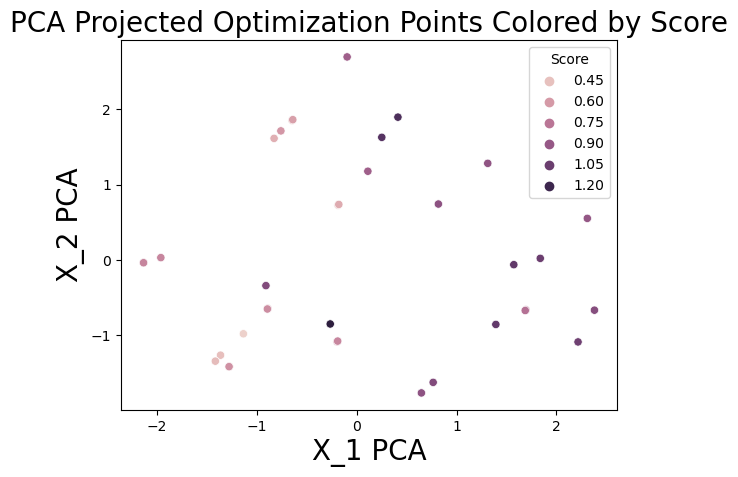

Text(0, 0.5, 'X_2 PCA')

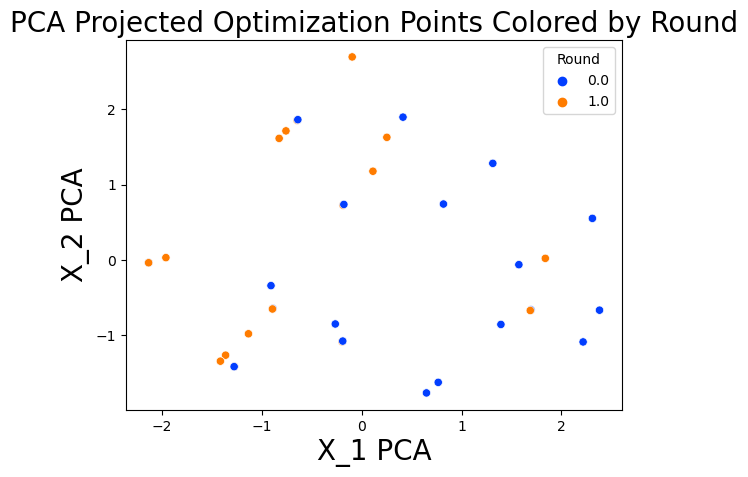

In [55]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = sklearn.decomposition.PCA(n_components = 2)
#Xpca = allX[-1][:,:-1]
Xpca = final_dataset.to_numpy()[:,:-2]
Xpca = scaler.fit_transform(Xpca)
pca.fit(Xpca)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)
newX = pca.fit_transform(Xpca)
Y = final_dataset.to_numpy()[:,-2]
Round = final_dataset.to_numpy()[:,-1]
Round = np.reshape(Round,(Round.shape[0], 1))

Y = np.reshape(Y,(Y.shape[0], 1))
print(newX.shape, Y.shape)

pca_data = np.hstack((newX, Y))
pca_data = np.hstack((pca_data, Round))
dataset = pd.DataFrame({'X_1 PCA': pca_data[:, 0], 'X_2 PCA': pca_data[:, 1], 'Score': pca_data[:,2], 'Round': pca_data[:,3]})
a = sns.scatterplot(data = dataset, x = 'X_1 PCA', y = 'X_2 PCA', hue = 'Score')
a.set_title("PCA Projected Optimization Points Colored by Score", fontsize=20)
a.set_xlabel("X_1 PCA", fontsize = 20)
a.set_ylabel("X_2 PCA", fontsize = 20)
plt.show()
plt.close()

a = sns.scatterplot(data = dataset, x = 'X_1 PCA', y = 'X_2 PCA', hue = 'Round', palette = 'bright')
a.set_title("PCA Projected Optimization Points Colored by Round", fontsize=20)
a.set_xlabel("X_1 PCA", fontsize = 20)
a.set_ylabel("X_2 PCA", fontsize = 20)

(36, 2) (36, 1)
[[-0.20832863  2.45413041  0.38196197  1.        ]
 [-1.73405147  4.53099918  0.40729684  1.        ]
 [-0.17051214  2.15631127  0.45199766  1.        ]
 [-0.0732207   2.05297637  0.46571713  1.        ]
 [-3.10173297  3.48528624  0.51000937  1.        ]
 [-2.64050221  3.27726912  0.51270144  1.        ]
 [ 0.6739406   2.64831161  0.52816788  1.        ]
 [-1.74313724  4.52924728  0.53272532  0.        ]
 [-3.17022347  3.41250396  0.5754742   0.        ]
 [-2.84403539  3.16466498  0.61103407  1.        ]
 [ 0.67429465  2.65027142  0.63362069  0.        ]
 [ 0.11764231  4.46538544  0.64583333  0.        ]
 [ 0.11963512  4.46790218  0.65104167  1.        ]
 [-1.626441    1.56373835  0.67424242  0.        ]
 [ 0.63399869  5.52004433  0.68092105  1.        ]
 [-1.80801189  2.11003494  0.68131868  1.        ]
 [ 0.63079965  5.51979208  0.68421053  0.        ]
 [-1.62487042  1.56435251  0.68644068  1.        ]
 [-0.80412835  6.35377789  0.74789916  0.        ]
 [-0.80301541  

Text(0.5, 1.0, 'tSNE Optimization Points Colored by Score')

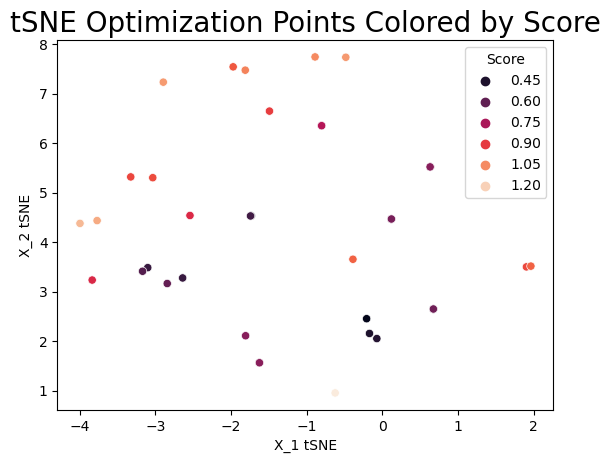

In [56]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
#Xfin, Y = allX[-1][:,:-1], allX[-1][:,-1]
Xfin, Y = final_dataset.to_numpy()[:, :-2], final_dataset.to_numpy()[:,-2]
Xfin = scaler.fit_transform(Xfin)
#Xfin, Y = Xtest, Ytest
newX = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=20).fit_transform(Xfin)
rounds = final_dataset.to_numpy()[:,-1]
Y = np.reshape(Y,(Y.shape[0], 1))
rounds = np.reshape(rounds, (rounds.shape[0],1))
print(newX.shape, Y.shape)
tsne_data = np.hstack((newX, Y))
tsne_data = np.hstack((tsne_data, rounds))
print(tsne_data)
dataset = pd.DataFrame({'X_1 tSNE': tsne_data[:, 0], 'X_2 tSNE': tsne_data[:, 1], 'Score': tsne_data[:,2], 'Round': tsne_data[:,3]})
dataset['Round'] = dataset['Round'].astype('int')
sns.scatterplot(data = dataset, x = 'X_1 tSNE', y = 'X_2 tSNE', hue = 'Score', palette = 'rocket').set_title('tSNE Optimization Points Colored by Score', fontsize=20)

Text(0, 0.5, 'X_2 tSNE')

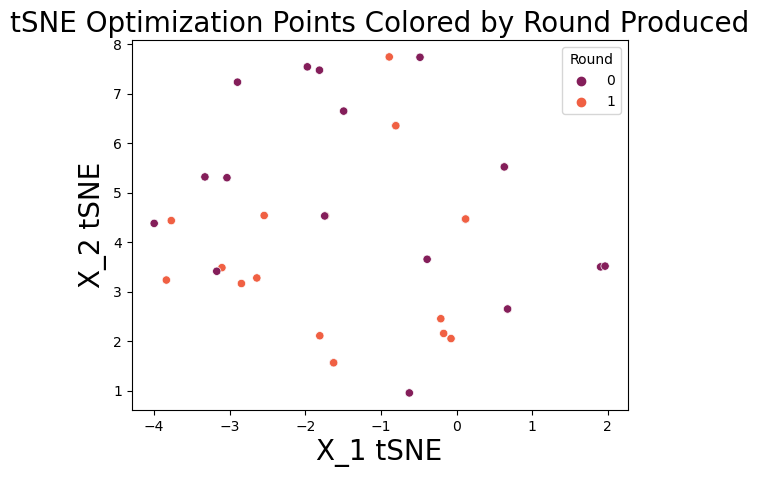

In [57]:
# POINTS EXPLORED FROM ONE ROUND TO THE NEXT PLOT
b = sns.scatterplot(data= dataset, x = 'X_1 tSNE', y = 'X_2 tSNE', hue = 'Round', legend = 'full', palette = 'rocket')
b.set_title("tSNE Optimization Points Colored by Round Produced", fontsize=20)
b.set_xlabel("X_1 tSNE", fontsize = 20)
b.set_ylabel("X_2 tSNE", fontsize = 20)

Text(0, 0.5, 'Score')

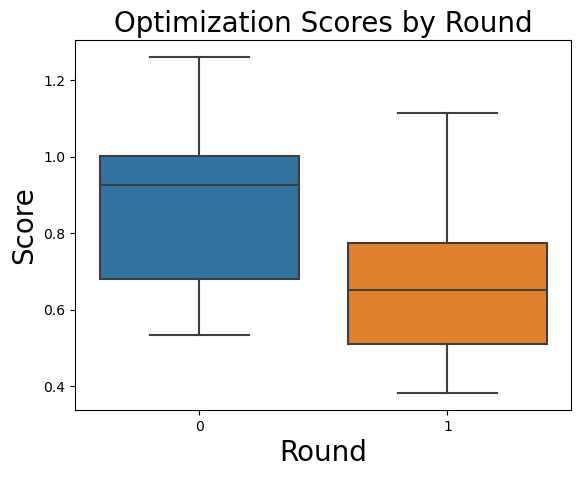

In [58]:
b = sns.boxplot(data = final_dataset, x = 'Round', y = 'Score')
b.set_title('Optimization Scores by Round',fontsize=20)
b.set_xlabel("Round",fontsize=20)
b.set_ylabel("Score",fontsize=20)